# Convolutional Neural Network for handwritten digits recognition

**Question 3 :** Bien analyser la structuration du script qui est assez standard et que vous retrouverez dans la suite des expérimentations. Attacher une importance particulière à la structuration des tableaux de données qui servent à l'apprentissage.

**Chargement des dépendances**

In [ ]:
import tensorflow
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Chargement du dataset**

In [ ]:
train_images=np.fromfile("dataset/mnist/train-images.idx3-ubyte", dtype=np.uint8)[16:].reshape(-1, 28, 28, 1)/255
train_labels=np.eye(10)[np.fromfile("dataset/mnist/train-labels.idx1-ubyte", dtype=np.uint8)[8:]]
test_images=np.fromfile("dataset/mnist/t10k-images.idx3-ubyte", dtype=np.uint8)[16:].reshape(-1, 28, 28, 1)/255
test_labels=np.eye(10)[np.fromfile("dataset/mnist/t10k-labels.idx1-ubyte", dtype=np.uint8)[8:]]

**Architecture du réseau neuronal**

Schéma de l'architecture du réseau convolutif : couche_prec -- x w --> result_conv --> + b --> result

**Définition des fonctions de normalisation, convolution, matmul :**

In [ ]:
def normalisation(couche_prec):
    mean, var=tf.nn.moments(couche_prec, [0])
    scale=tf.Variable(tf.ones(shape=(np.shape(couche_prec)[-1])))
    beta=tf.Variable(tf.zeros(shape=(np.shape(couche_prec)[-1])))
    result=tf.nn.batch_normalization(couche_prec, mean, var, beta, scale, 0.001)
    return result

In [ ]:
def convolution(couche_prec, taille_noyau, nbr_noyau):
    w=tf.Variable(tf.random.truncated_normal(shape=(taille_noyau, taille_noyau, int(couche_prec.get_shape()[-1]), nbr_noyau)))
    b=np.zeros(nbr_noyau)
    result=tf.nn.conv2d(couche_prec, w, strides=[1, 1, 1, 1], padding='SAME')+b
    return result

In [ ]:
# Fonction pour ajouter une couche
def fc1(couche_prec, nbr_neurone):
    w=tf.Variable(tf.random.truncated_normal(shape=(int(couche_prec.get_shape()[-1]), nbr_neurone), dtype=tf.float32))
    b=tf.Variable(np.zeros(shape=(nbr_neurone)), dtype=tf.float32)
    result=tf.matmul(couche_prec, w)+b
    return result

In [ ]:
# Paramètres du réseau
learning_rate=0.001
taille_batch=100
epoch_nbr=20

# Ces 2 placeholders représentent les endroits où seront placés l'image d'entrée et le résultat du réseau
ph_images=tf.placeholder(shape=(None, 28, 28, 1), dtype=tf.float32)
ph_labels=tf.placeholder(shape=(None, 10), dtype=tf.float32)

In [ ]:
# 1ère couche
result=convolution(ph_images, 5, 16)
result=normalisation(result)
result=tf.nn.relu(result) # Relu

# 2ème couche
result=convolution(result, 5, 16)
result=normalisation(result)
result=tf.nn.relu(result) # Relu
result=tf.nn.max_pool(result, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') # Pooling

# 3ème couche
result=convolution(result, 5, 32)
result=normalisation(result)
result=tf.nn.relu(result)

# 4ème couche
result=convolution(result, 5, 32)
result=normalisation(result)
result=tf.nn.relu(result)
result=tf.nn.max_pool(result, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# On applati le résultat de la dernière couche
result=tf.layers.flatten(result)
# Couche connectée à une couche fc1 de 512 neurones
result=fc1(result, 512)
result=normalisation(result)
# Neurones activés par une fonction sigmoid
result=tf.nn.sigmoid(result)
# Couche connectée à une couche fc2 de 10 neurones
result=fc1(result, 10)

scso=tf.nn.softmax(result,name='sortie')

# Fonctions de loss, apprentissage et métrique de précision
loss=tf.nn.softmax_cross_entropy_with_logits_v2(labels=ph_labels, logits=result)
train=tf.train.AdamOptimizer(learning_rate).minimize(loss)
#train=tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
accuracy=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(scso, 1), tf.argmax(ph_labels, 1)), tf.float32))

# Instanciation de la classe sauvegarde
saver=tf.train.Saver()

<ipython-input-33-deb10baf7099>:24: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  result=tf.layers.flatten(result)


In [ ]:
# Cette session regroupe les différentes itérations d'apprentissage et les prédictions sur la base de test :
# Fonction qui entraînera notre modèle
with tf.Session() as s:

    # Initialisation des variables
    s.run(tf.global_variables_initializer())

    tab_acc_train=[]
    tab_acc_test=[]

    for id_entrainement in range(epoch_nbr):
        print("ID entrainement", id_entrainement)
        for batch in range(0, len(train_images), taille_batch):
            # lancement de l'apprentissage en passant la commande "train". feed_dict est l'option désignant ce qui est
            # placé dans les placeholders
            s.run(train, feed_dict={
                ph_images: train_images[batch:batch+taille_batch],
                ph_labels: train_labels[batch:batch+taille_batch]
            })

        # Prédiction du modèle sur les batchs du dataset de training
        tab_acc=[]
        for batch in range(0, len(train_images), taille_batch):
            # lancement de la prédiction en passant la commande "accuracy". feed_dict est l'option désignant ce qui est
            # placé dans les placeholders
            acc=s.run(accuracy, feed_dict={
                ph_images: train_images[batch:batch+taille_batch],
                ph_labels: train_labels[batch:batch+taille_batch]
            })
            # création le tableau des accuracies
            tab_acc.append(acc)

        # calcul de la moyenne des accuracies
        print("accuracy train:", np.mean(tab_acc))
        tab_acc_train.append(1-np.mean(tab_acc))

        # Prédiction du modèle sur les batchs du dataset de test
        tab_acc=[]
        for batch in range(0, len(test_images), taille_batch):
            acc=s.run(accuracy, feed_dict={
                ph_images: test_images[batch:batch+taille_batch],
                ph_labels: test_labels[batch:batch+taille_batch]
            })
            tab_acc.append(acc)
        print("accuracy test :", np.mean(tab_acc))
        tab_acc_test.append(1-np.mean(tab_acc))
        # sauvegarde du réseau
        saver.save(s,"model_mnist")

        resulat=s.run(scso, feed_dict={ph_images: test_images[0:taille_batch]})
        # Dernière ligne applique de modèle obtenu sur un batch d'images de test. Le résultat sera ensuite affiché (courbe et décision).

ID entrainement 0
accuracy train: 0.94553334
accuracy test : 0.9345
ID entrainement 1
accuracy train: 0.9703833
accuracy test : 0.95579994
ID entrainement 2
accuracy train: 0.98118335
accuracy test : 0.9642999
ID entrainement 3
accuracy train: 0.98698336
accuracy test : 0.96669996
ID entrainement 4
accuracy train: 0.99113333
accuracy test : 0.96830004
ID entrainement 5
accuracy train: 0.9930168
accuracy test : 0.96800005
ID entrainement 6
accuracy train: 0.9959334
accuracy test : 0.9694001
ID entrainement 7
accuracy train: 0.9977666
accuracy test : 0.9707001
ID entrainement 8
accuracy train: 0.99884987
accuracy test : 0.9722001
ID entrainement 9
accuracy train: 0.9994334
accuracy test : 0.9735001
ID entrainement 10
accuracy train: 0.99966675
accuracy test : 0.97450006
ID entrainement 11
accuracy train: 0.9998167
accuracy test : 0.97560006
ID entrainement 12
accuracy train: 0.9999166
accuracy test : 0.9763001
ID entrainement 13
accuracy train: 0.9999666
accuracy test : 0.9772001
ID entr

**Affichage de l'évolution des erreurs réalisées par notre modèle au cours des itérations**

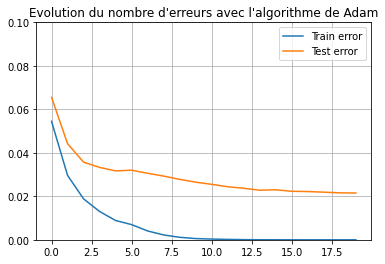

In [ ]:
plt.ylim(0, 0.1)
plt.grid()
plt.plot(tab_acc_train, label="Train error")
plt.plot(tab_acc_test, label="Test error")
plt.legend(loc="upper right")
plt.title("Evolution du nombre d'erreurs avec l'algorithme de Adam" )
plt.show()

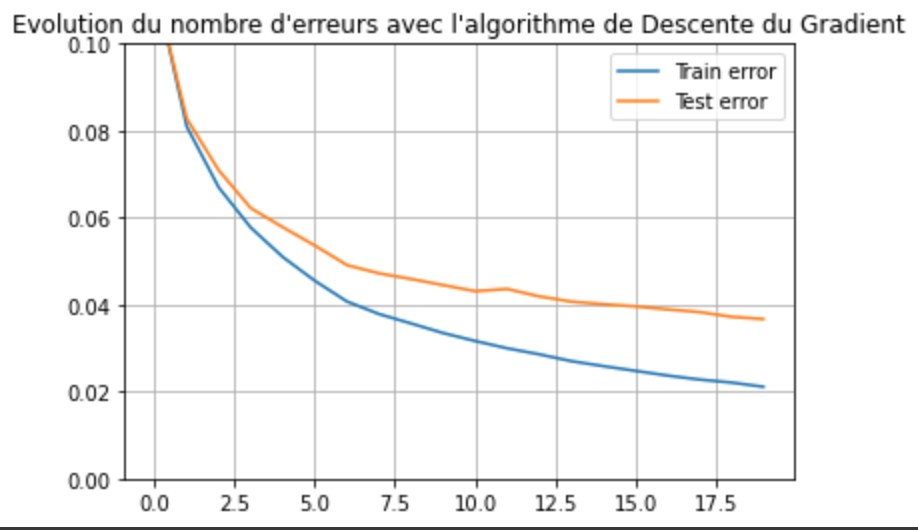

**Question 4 :** Vous comparerez les performances du modèle obtenu avec l'une et l'autre méthode d'optimisation. Par ailleurs, vous observerez comment varie les courbes de performance. Pour cette cette dernère observation, vous pourrez augmenter le nombre d'époch.

Lorsqu'on compare ces deux algorithmes, on observe que l'algorithme d'Adam est plus performant que l'algorithme de Descente du Gradient.

**Affichage du résultat obtenu pour chaque image test du batch**

In [ ]:
np.set_printoptions(formatter={'float': '{:0.3f}'.format})
for image in range(taille_batch):
     print("image", image)
     print("sortie du réseau:", resulat[image], np.argmax(resulat[image]))
     print("sortie attendue :", test_labels[image], np.argmax(test_labels[image]))
     cv2_imshow(test_images[image].reshape(28, 28))
     if cv2.waitKey()&0xFF==ord('q'):
         break

image 0
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 1
sortie du réseau: [0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2
sortie attendue : [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2


image 2
sortie du réseau: [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 3
sortie du réseau: [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0
sortie attendue : [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0


image 4
sortie du réseau: [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 5
sortie du réseau: [0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 6
sortie du réseau: [0.000 0.000 0.000 0.000 0.872 0.000 0.000 0.000 0.126 0.001] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 7
sortie du réseau: [0.000 0.000 0.000 0.000 0.001 0.000 0.000 0.000 0.000 0.998] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 8
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.975 0.021 0.000 0.004 0.000] 5
sortie attendue : [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5


image 9
sortie du réseau: [0.000 0.000 0.000 0.000 0.001 0.000 0.000 0.000 0.004 0.995] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 10
sortie du réseau: [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0
sortie attendue : [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0


image 11
sortie du réseau: [0.001 0.000 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 12
sortie du réseau: [0.000 0.000 0.000 0.000 0.005 0.000 0.000 0.000 0.001 0.994] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 13
sortie du réseau: [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0
sortie attendue : [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0


image 14
sortie du réseau: [0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 15
sortie du réseau: [0.000 0.000 0.000 0.106 0.000 0.890 0.000 0.000 0.004 0.000] 5
sortie attendue : [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5


image 16
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 17
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 18
sortie du réseau: [0.000 0.000 0.000 0.994 0.000 0.002 0.000 0.000 0.003 0.000] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 19
sortie du réseau: [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 20
sortie du réseau: [0.000 0.000 0.000 0.003 0.008 0.000 0.000 0.004 0.000 0.985] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 21
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 22
sortie du réseau: [0.000 0.000 0.000 0.000 0.026 0.000 0.974 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 23
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5
sortie attendue : [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5


image 24
sortie du réseau: [0.000 0.000 0.000 0.000 0.998 0.000 0.000 0.000 0.000 0.002] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 25
sortie du réseau: [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0
sortie attendue : [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0


image 26
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 27
sortie du réseau: [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 28
sortie du réseau: [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0
sortie attendue : [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0


image 29
sortie du réseau: [0.000 0.997 0.000 0.000 0.000 0.001 0.000 0.000 0.001 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 30
sortie du réseau: [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 31
sortie du réseau: [0.000 0.993 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.005] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 32
sortie du réseau: [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 33
sortie du réseau: [0.863 0.000 0.006 0.000 0.124 0.002 0.005 0.000 0.000 0.000] 0
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 34
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 35
sortie du réseau: [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2
sortie attendue : [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2


image 36
sortie du réseau: [0.000 0.001 0.010 0.007 0.000 0.000 0.000 0.959 0.002 0.020] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 37
sortie du réseau: [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 38
sortie du réseau: [0.002 0.001 0.993 0.004 0.000 0.000 0.000 0.000 0.000 0.000] 2
sortie attendue : [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2


image 39
sortie du réseau: [0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.000 0.001 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 40
sortie du réseau: [0.001 0.995 0.001 0.000 0.000 0.001 0.000 0.001 0.000 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 41
sortie du réseau: [0.000 0.000 0.002 0.002 0.000 0.000 0.000 0.996 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 42
sortie du réseau: [0.000 0.000 0.000 0.000 0.995 0.000 0.000 0.000 0.000 0.005] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 43
sortie du réseau: [0.000 0.001 0.995 0.000 0.000 0.003 0.000 0.000 0.000 0.000] 2
sortie attendue : [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2


image 44
sortie du réseau: [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 45
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5
sortie attendue : [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5


image 46
sortie du réseau: [0.000 0.997 0.002 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 47
sortie du réseau: [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2
sortie attendue : [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2


image 48
sortie du réseau: [0.000 0.000 0.000 0.000 0.995 0.000 0.000 0.000 0.000 0.005] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 49
sortie du réseau: [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 50
sortie du réseau: [0.002 0.000 0.000 0.000 0.000 0.002 0.996 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 51
sortie du réseau: [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 52
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5
sortie attendue : [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5


image 53
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5
sortie attendue : [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5


image 54
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 55
sortie du réseau: [0.999 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.001 0.000] 0
sortie attendue : [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0


image 56
sortie du réseau: [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 57
sortie du réseau: [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 58
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 59
sortie du réseau: [0.000 0.000 0.000 0.000 0.001 0.997 0.000 0.003 0.000 0.000] 5
sortie attendue : [0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000] 5


image 60
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.999 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 61
sortie du réseau: [0.000 0.000 0.036 0.000 0.000 0.007 0.000 0.000 0.956 0.000] 8
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000] 8


image 62
sortie du réseau: [0.000 0.000 0.001 0.000 0.000 0.961 0.000 0.005 0.006 0.028] 5
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 63
sortie du réseau: [0.000 0.000 0.001 0.999 0.000 0.000 0.000 0.000 0.000 0.000] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 64
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 65
sortie du réseau: [0.000 0.001 0.000 0.002 0.992 0.000 0.000 0.000 0.000 0.004] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 66
sortie du réseau: [0.012 0.000 0.000 0.000 0.000 0.000 0.987 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 67
sortie du réseau: [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 68
sortie du réseau: [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 69
sortie du réseau: [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0
sortie attendue : [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0


image 70
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 71
sortie du réseau: [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0
sortie attendue : [1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 0


image 72
sortie du réseau: [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2
sortie attendue : [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2


image 73
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.005 0.008 0.986] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 74
sortie du réseau: [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 75
sortie du réseau: [0.000 0.000 0.000 0.001 0.000 0.000 0.000 0.999 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 76
sortie du réseau: [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 77
sortie du réseau: [0.002 0.000 0.994 0.000 0.000 0.001 0.000 0.002 0.000 0.000] 2
sortie attendue : [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2


image 78
sortie du réseau: [0.000 0.000 0.000 0.000 0.003 0.000 0.000 0.000 0.004 0.994] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 79
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 80
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.040 0.000 0.959] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 81
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 82
sortie du réseau: [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2
sortie attendue : [0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 2


image 83
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 84
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000] 8
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000] 8


image 85
sortie du réseau: [0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.001] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 86
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 87
sortie du réseau: [0.000 0.000 0.000 0.371 0.000 0.499 0.000 0.130 0.000 0.000] 5
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 88
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 89
sortie du réseau: [0.001 0.998 0.000 0.000 0.000 0.000 0.001 0.000 0.000 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 90
sortie du réseau: [0.000 0.000 0.000 0.998 0.000 0.000 0.000 0.000 0.001 0.000] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 91
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 92
sortie du réseau: [0.000 0.005 0.001 0.000 0.005 0.001 0.000 0.001 0.637 0.348] 8
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9


image 93
sortie du réseau: [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3
sortie attendue : [0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000] 3


image 94
sortie du réseau: [0.000 0.995 0.001 0.000 0.000 0.000 0.000 0.000 0.005 0.000] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 95
sortie du réseau: [0.000 0.000 0.000 0.000 0.955 0.000 0.017 0.000 0.007 0.021] 4
sortie attendue : [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000] 4


image 96
sortie du réseau: [0.000 0.699 0.001 0.002 0.008 0.009 0.000 0.005 0.005 0.270] 1
sortie attendue : [0.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000] 1


image 97
sortie du réseau: [0.000 0.001 0.002 0.000 0.001 0.000 0.000 0.983 0.013 0.000] 7
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000] 7


image 98
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000] 6


image 99
sortie du réseau: [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9
sortie attendue : [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000] 9
